Transfer learning / fine-tuning This tutorial will guide you through the process of using transfer learning to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from ILSVRC), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

Feature extraction vs. fine-tuning At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [1] [2].

Procedure In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, VGG16 which won the ImageNet challenge in 2014, and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.

As our test subject, we'll use a dataset consisting of around 6000 images belonging to 97 classes, and train an image classifier with around 80% accuracy on it. It's worth noting that this strategy scales well to image sets where you may have even just a couple hundred or less images. Its performance will be lesser from a small number of samples (depending on classes) as usual, but still impressive considering the usual constraints.

!pip install keras

In [4]:

%matplotlib inline

import os

# if using Theano with GPU
# os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model



In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar https://www.tensorflow.org/datasets/catalog/cats_vs_dogs
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

In [5]:
import os

file_path = r"PetImages"

if os.path.exists(file_path):
    print(f"Tamanho do arquivo: {os.path.getsize(file_path)} bytes")
else:
    print("Arquivo não encontrado!")


Tamanho do arquivo: 0 bytes


In [6]:
root = r"PetImages"

train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root)]]

print(categories)

['PetImages\\Cat', 'PetImages\\Dog']


In [7]:
root = '101_Object_Categories/PetImages'


train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root)]]

print(categories)

['101_Object_Categories/PetImages\\Cat', '101_Object_Categories/PetImages\\Dog']


Esta função é útil para pré-processar os dados em uma imagem e um vetor de entrada.

In [8]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz  (usar apenas se o computador suportar)

In [ ]:
import os
import cv2
import numpy as np

data = []
image_size = (224, 224)  # Tamanho fixo das imagens

def get_image(img_path):
    """Função para carregar e processar a imagem"""
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {img_path}")
    
    img = cv2.imread(img_path)  # Carrega a imagem
    if img is None:
        raise ValueError(f"Falha ao carregar imagem: {img_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converte para RGB
    img = cv2.resize(img, image_size)  # Redimensiona
    return img  # Retorna a imagem processada

for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
    
    for img_path in images:
        try:
            print(f"Tentando carregar: {img_path}")  # Log para depuração
            img = get_image(img_path)  # Carrega a imagem
            
            img_array = np.array(img, dtype=np.float32)  # Converte para array NumPy

            data.append({'x': img_array, 'y': c})
        
        except Exception as e:
            print(f"Erro ao carregar imagem {img_path}: {e}")

# Contar o número de classes
num_classes = len(categories)


Carrega uma quantidade limitada de imagens para não sobrecarregar as o processador

In [9]:
import os
import cv2
import numpy as np

data = []
image_size = (224, 224)  # Tamanho fixo das imagens
max_images = 2000  # Limite de imagens por classe
max_total_images = 10000  # Limite total para evitar uso excessivo de memória

def get_image(img_path):
    """Função para carregar e processar a imagem"""
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {img_path}")
    
    img = cv2.imread(img_path)  # Carrega a imagem
    if img is None:
        raise ValueError(f"Falha ao carregar imagem: {img_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converte para RGB
    img = cv2.resize(img, image_size)  # Redimensiona
    return img  # Retorna a imagem processada

total_loaded = 0  # Contador de imagens carregadas

for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
    
    images = images[:max_images]  # Limita a quantidade de imagens por classe
    
    for img_path in images:
        if total_loaded >= max_total_images:
            break  # Interrompe quando atingir o máximo global
        
        try:
            print(f"Tentando carregar: {img_path}")  # Log para depuração
            img = get_image(img_path)  # Carrega a imagem
            
            img_array = np.array(img, dtype=np.float32)  # Converte para array NumPy

            data.append({'x': img_array, 'y': c})
            total_loaded += 1  # Atualiza o contador de imagens carregadas
        
        except Exception as e:
            print(f"Erro ao carregar imagem {img_path}: {e}")

    if total_loaded >= max_total_images:
        break  # Interrompe completamente ao atingir o limite

# Contar o número de classes
num_classes = len(categories)

print(f"Total de imagens carregadas: {total_loaded}")


Tentando carregar: 101_Object_Categories/PetImages\Cat\0.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\1.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\100.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\1000.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10000.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10001.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10002.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10003.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10004.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10005.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10006.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10007.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10008.jpg
Tentando carregar: 101_Object_Categories/PetImages\Cat\10009.jpg
Tentando carregar: 101_Object_Categorie

Randomize a ordem dos dados.

In [10]:
random.shuffle(data)

criar divisão de treinamento/validação/teste (70%, 15%, 15%)

In [11]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [23]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)
print((y_test))

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 

In [14]:
x_train = np.array([t["x"] for t in train], dtype=np.float16)
y_train = np.array([t["y"] for t in train], dtype=np.float16)
x_val = np.array([t["x"] for t in val], dtype=np.float16)
y_val = np.array([t["y"] for t in val], dtype=np.float16)
x_test = np.array([t["x"] for t in test], dtype=np.float16)
y_test = np.array([t["y"] for t in test], dtype=np.float16)
print(y_test)

[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.

Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [24]:
# Verificar tamanhos dos dados
print(f"Tamanho de y_train: {len(y_train)}")
print(f"Tamanho de y_val: {len(y_val)}")
print(f"Tamanho de y_test: {len(y_test)}")

# Checar número de classes
print(f"Número de classes: {num_classes}")

# Caso os dados estejam corretos, continuar
if len(y_train) > 0 and len(y_val) > 0 and len(y_test) > 0:
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print(f"Shape de y_test após one-hot encoding: {y_test.shape}")
else:
    print("Os dados estão vazios. Verifique o carregamento e a divisão.")


Tamanho de y_train: 2790
Tamanho de y_val: 598
Tamanho de y_test: 599
Número de classes: 2
Shape de y_test após one-hot encoding: (599, 2)


In [25]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 3987 images from 2 categories
train / validation / test split: 2790, 598, 599
training data shape:  (2790, 224, 224, 3)
training labels shape:  (2790, 2)


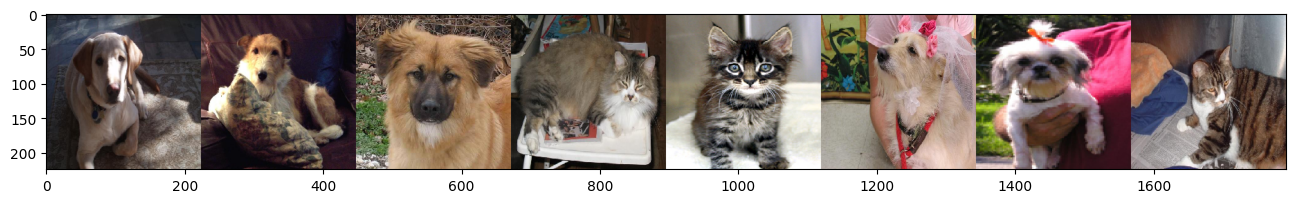

In [27]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [ image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16, 4))
plt.imshow(concat_image)

First training a neural net from scratch

In [29]:
# build the network
model = Sequential()
print("Input dimensions:", x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()



Input dimensions: (224, 224, 3)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,748,002 (18.11 MB)

 Trainable params: 4,748,002 (18.11 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.5205 - loss: 159.1569 - val_accuracy: 0.4548 - val_loss: 2.9930
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.5165 - loss: 0.6923 - val_accuracy: 0.4582 - val_loss: 1.5603
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.5016 - loss: 0.6913 - val_accuracy: 0.4649 - val_loss: 1.4780
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5281 - loss: 0.6886 - val_accuracy: 0.4649 - val_loss: 1.5994
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5481 - loss: 0.6876 - val_accuracy: 0.4632 - val_loss: 1.6003
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.5376 - loss: 0.6855 - val_accuracy: 0.4866 - val_loss: 1.2138
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.5472 - loss: 0.6837 - val_accuracy: 0.4716 - val_loss: 1.6646
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5522 - loss: 0.6817 - val_accuracy: 0.4649 - val_l

Let's plot the validation loss and validation accuracy over time.

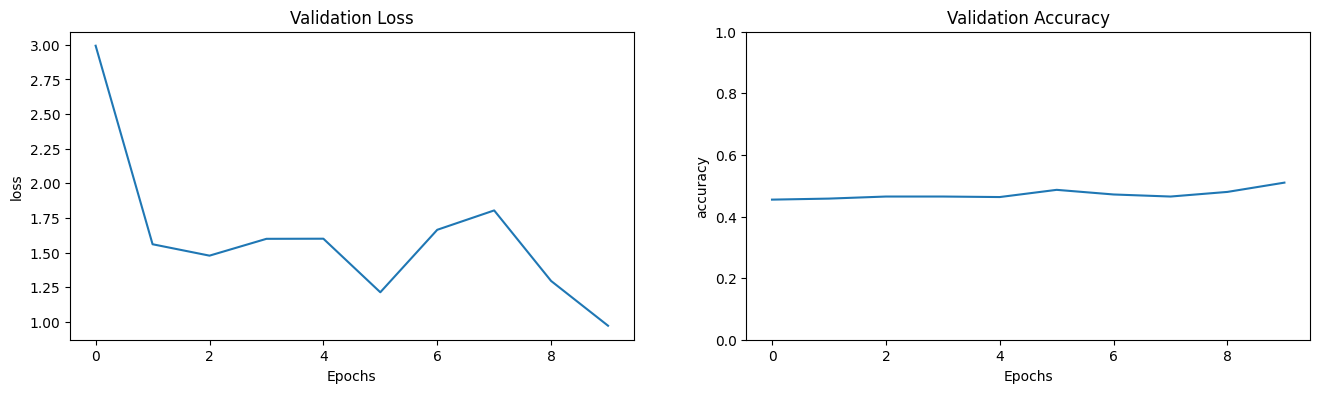

In [31]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history[("val_loss")])
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("loss")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("accuracy")
ax2.set_ylim(0, 1)

plt.show()

In [34]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Test loss: 0.9072733521461487
Test accuracy: 0.5258764624595642


In [35]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True,)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# make a reference to the VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inputs=inp, outputs=out)

In [38]:
# make all layers untrainable by freezing weigthts (except for our new last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True 

model_new.compile(loss = 'categorial_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

model_new.summary()

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [40]:
history2 = model.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.5689 - loss: 0.6710 - val_accuracy: 0.5000 - val_loss: 1.2442
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.5780 - loss: 0.6669 - val_accuracy: 0.4967 - val_loss: 1.2178
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.5911 - loss: 0.6634 - val_accuracy: 0.4967 - val_loss: 1.2355
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.5850 - loss: 0.6700 - val_accuracy: 0.4799 - val_loss: 1.3797
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.5666 - loss: 0.6742 - val_accuracy: 0.4816 - val_loss: 1.4960
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.5838 - loss: 0.6606 - val_accuracy: 0.4900 - val_loss: 1.3682
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.5811 - loss: 0.6557 - val_accuracy: 0.4849 - val_loss: 1.4891
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.6019 - loss: 0.6534 - val_accuracy: 0.4833 - val_l

texto

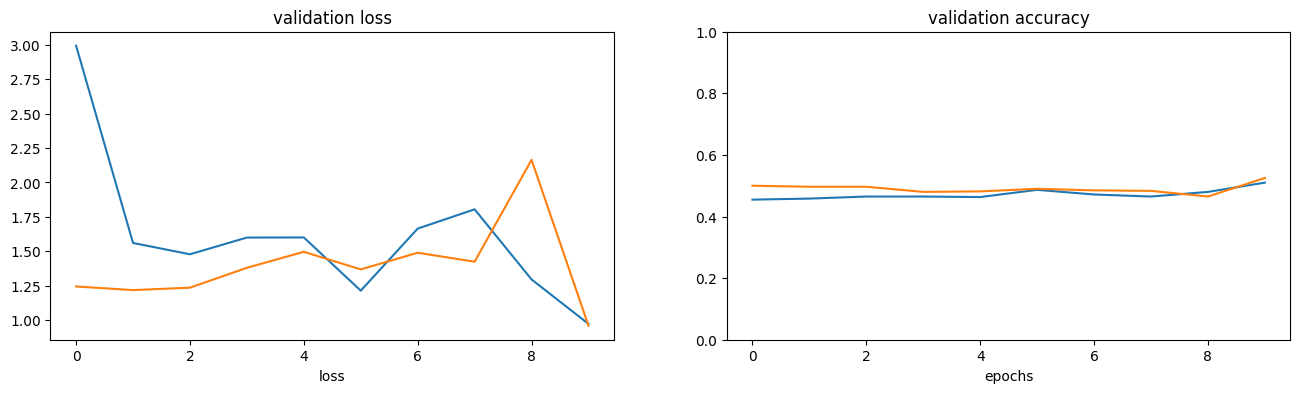

In [41]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")
ax.set_xlabel("loss")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [42]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

print("Test loss:", loss)
print("Test accuracy:", accuracy)


Test loss: 0.8886734843254089
Test accuracy: 0.544240415096283


To predict a new image, simply run the following code to get the probabilities for each class.

In [78]:
img, x = get_image('101_Object_Categories/PetImages/Cat/100.jpg')

# Garante que 'x' está no formato correto
x = np.array(x)  

# Faz a predição corretamente
probabilities = model_new.predict(x)  

# Exibe o valor previsto
print(probabilities[0][0])  # Ajuste conforme a saída do modelo


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0.95784014
